# Sider+Offsides Multitask Classifier

In [1]:
import numpy as np
import tensorflow as tf
import deepchem as dc

/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
"""
OFFSIDES dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_sider_offsides(featurizer='ECFP', split='index', reload=True, K=4):
  logger.info("About to load sider+ofssides dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "sideroffsides/" + featurizer + "/" + str(split))

  dataset_file = os.path.join("./", "sider+offsides_combined.csv.gz")


  dataset = deepchem.utils.save.load_from_disk(dataset_file)
  logger.info("Columns of dataset: %s" % str(dataset.columns.values))
  logger.info("Number of examples in dataset: %s" % str(dataset.shape[0]))
  SIDER_OFFSIDES_tasks = dataset.columns.values[1:].tolist()

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_dir)
    if loaded:
      return SIDER_OFFSIDES_tasks, all_dataset, transformers

  # Featurize OFFSIDES dataset
  logger.info("About to featurize OFFSIDES dataset.")
  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  logger.info("SIDER OFFSIDES tasks: %s" % str(SIDER_OFFSIDES_tasks))
  logger.info("%d tasks in total" % len(SIDER_OFFSIDES_tasks))

  loader = deepchem.data.CSVLoader(
      tasks=SIDER_OFFSIDES_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)
  logger.info("%d datapoints in SIDER OFFSIDES dataset" % len(dataset))

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return SIDER_OFFSIDES_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
    all_dataset = (train, valid, test)
  return SIDER_OFFSIDES_tasks, all_dataset, transformers


In [3]:
Sideroffsides_tasks, Sideroffsides_datasets, transformers = load_sider_offsides(featurizer='GraphConv',reload=True)
train_dataset, valid_dataset, test_dataset = Sideroffsides_datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./sider+offsides_combined.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 5.617 s
TIMING: dataset construction took 7.137 s
Loading dataset from disk.
TIMING: dataset construction took 0.959 s
Loading dataset from disk.
TIMING: dataset construction took 0.842 s
Loading dataset from disk.
TIMING: dataset construction took 0.376 s
Loading dataset from disk.
TIMING: dataset construction took 0.378 s
Loading dataset from disk.


In [4]:
featurizer = dc.feat.CircularFingerprint(size = 1352)

In [5]:
loader = dc.data.CSVLoader(tasks=Sideroffsides_tasks, 
                           smiles_field="smiles",
                           featurizer=featurizer)

In [6]:
dataset = loader.featurize('sider+offsides_combined.csv')
len(dataset)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from sider+offsides_combined.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.740 s
TIMING: dataset construction took 3.839 s
Loading dataset from disk.


1690

In [7]:
train_dataset.y.shape

(1352, 27)

In [8]:
valid_dataset.y.shape

(169, 27)

In [9]:
test_dataset.y.shape

(169, 27)

In [10]:
splitter = dc.splits.RandomSplitter('offsides.csv')
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset

Computing train/valid/test indices
TIMING: dataset construction took 0.169 s
Loading dataset from disk.
TIMING: dataset construction took 0.060 s
Loading dataset from disk.
TIMING: dataset construction took 0.060 s
Loading dataset from disk.


In [11]:
n_features = train_dataset.y.shape[0]
n_features

1352

In [12]:
params_dict = {"activation": ["relu"],
               "optimizer": ["Adam"],
               "momentum": [.9],
               "penalty": [0.]
              }


n_features = train_dataset.y.shape[0]
def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(Sideroffsides_tasks), n_features, **model_params)
    return model

In [13]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/1
hyperparameters: {'activation': 'relu', 'optimizer': 'Adam', 'momentum': 0.9, 'penalty': 0.0}
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


computed_metrics: [0.4985361093038386, 0.5860515688101895, 0.4527426160337553, 0.46494252873563213, 0.5341932841932842, 0.5553376295881198, 0.6336152882205515, 0.6052757793764988, 0.5741106719367588, 0.6281156530408774, 0.7008658008658009, 0.6074950690335306, 0.4484848484848485, 0.5748966942148761, 0.5628881987577641, 0.40775401069518713, 0.5637522768670309, 0.5443636363636364, 0.5177514792899408, 0.5314625850340137, 0.5291806958473624, 0.5171156004489338, 0.551931008623922, 0.5963302752293578, 0.5792349726775956, 0.5670037926675096, 0.5334827682824321]
Model 1/1, Metric mean-roc_auc_score, Validation set 0: 0.550626
	best_validation_score so far: 0.550626
computed_metrics: [0.9140633834849106, 0.9019010407741257, 0.8993881754035788, 0.9096054314900435, 0.9214842308047251, 0.8940018741064607, 0.9159372305486393, 0.9274721841315026, 0.9129573478876087, 0.9155981728871139, 0.9363563189731804, 0.9105810937545793, 0.8716270664941027, 0.9130503204518052, 0.9303614561766735, 0.90862828073336

In [14]:
best_dnn

MultitaskClassifier(activation_fns=None, bias_init_consts=None, dropouts=None,
                    layer_sizes=None, n_classes=2, n_features=1352, n_tasks=27,
                    weight_decay_penalty=None, weight_decay_penalty_type=None,
                    weight_init_stddevs=None)

In [15]:
best_hyperparams

('relu', 'Adam', 0.9, 0.0)

In [16]:
all_results

{"('relu', 'Adam', 0.9, 0.0)": 0.5506264756527128}

In [17]:
model=model_builder(params_dict,params_dict)

In [18]:
model.fit(train_dataset, nb_epoch=100)

214.3611163284416

In [19]:
obj=best_dnn.fit(train_dataset,**params_dict,epochs=100)

In [20]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [21]:
train_scores = model.evaluate(train_dataset, [metric], transformers)

computed_metrics: [0.9993654615042458, 0.9997595137722635, 0.9998117799488742, 0.9993642263587474, 0.9988997900516796, 0.9996245218948618, 0.9998001821370097, 0.9995165853743209, 0.9993876264878297, 0.9995369095165956, 0.9991544348806453, 0.9996983773433761, 0.9987546091670534, 0.9997817120375658, 0.9999007936507937, 0.9998358978656248, 0.9996450635048539, 0.9995803917497231, 0.9998744559758955, 0.9994364375461936, 0.9992324986687879, 0.999749426087261, 0.9997121598088741, 0.9992303069526627, 0.9996269070833343, 0.9993286506116208, 0.9994286216596343]


In [22]:
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

computed_metrics: [0.4995120364346129, 0.6036036036036037, 0.48699015471167373, 0.4422413793103449, 0.4561834561834562, 0.5318016251050715, 0.5751488095238095, 0.6059952038369305, 0.5979319593450028, 0.5772681954137586, 0.6787878787878787, 0.5766354372123603, 0.4181818181818182, 0.5259986225895317, 0.47457298136645965, 0.5271836007130124, 0.5670916818457802, 0.5206363636363636, 0.5927021696252466, 0.5899659863945579, 0.5126262626262627, 0.5390361952861953, 0.5962223472065993, 0.6155581039755351, 0.5297131147540983, 0.5200695322376738, 0.56945222751471]


In [23]:
test_scores = model.evaluate(test_dataset, [metric], transformers)

computed_metrics: [0.4559206245933637, 0.5296502976190477, 0.5364247688428132, 0.6359180035650625, 0.5331960626757734, 0.4971988795518207, 0.5606026785714284, 0.4570668693009119, 0.4866842259291776, 0.5309405940594059, 0.5180180180180181, 0.49117599219258296, 0.7065439672801637, 0.5182795698924731, 0.5419320594479831, 0.561726659167604, 0.569378698224852, 0.5290794283815221, 0.5098245614035088, 0.5118049083566325, 0.5307935393258427, 0.5245098039215687, 0.6169823861748088, 0.5289232531500573, 0.5242486338797814, 0.5080128205128205, 0.5224789915966387]


In [24]:
print(train_scores)
print(valid_scores)
print(test_scores)

{'mean-roc_auc_score': 0.9995199015422345}
{'mean-roc_auc_score': 0.5455966943489757}
{'mean-roc_auc_score': 0.5347154183568764}


In [25]:
import seaborn as sns


sns.set(rc={'figure.figsize':(10,4)})

sns.set(style="whitegrid")
ax = sns.barplot(x=test_scores['mean-roc_auc_score'],
                    y=['First Scenario'])
                    
ax.set(xlim=(0.0, None))

[(0.0, 0.5614511892747203)]


# Changing the most important hyperparameters

In [30]:
params_dict = {"activation": ["relu","sigmoid","tanh"],
               "optimizer": ['RMSprop','adam'],
               "momentum": [.9],
               "dropouts": [.5,0.2],
               "nb_layers": [512],
               "penalty": [0.]
              }

n_features = train_dataset.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(Sideroffsides_tasks), n_features, **model_params)
    return model

In [31]:

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.5, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.49235523747560184, 0.5879155017086052, 0.45879043600562586, 0.443103448275862, 0.5237510237510237, 0.5542168674698795, 0.6337719298245614, 0.5971223021582734, 0.5875211744776963, 0.6169823861748089, 0.7025974025974026, 0.60387902695595, 0.3787878787878788, 0.5633608815426998, 0.563664596273292, 0.4336007130124777, 0.5473588342440802, 0.5409090909090909, 0.4822485207100592, 0.5290816326530612, 0.526374859708193, 0.5051907968574636, 0.5560554930633671, 0.5906727828746178, 0.5551001821493624, 0.5418773704171934, 0.5372653404314933]
Model 1/12, Metric mean-roc_auc_score, Validation set 0: 0.542724
	best_validation_score so far: 0.542724
Fitting model 2/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.476740403383214

computed_metrics: [0.49544567338972023, 0.6053122087604847, 0.4565400843881856, 0.44051724137931036, 0.5341932841932842, 0.5616419165032223, 0.6489661654135338, 0.6155875299760192, 0.5807453416149069, 0.6221335992023929, 0.6787878787878787, 0.6111111111111112, 0.4196969696969697, 0.5771349862258953, 0.5892857142857143, 0.4193404634581105, 0.5529751062537948, 0.5365454545454545, 0.5133136094674555, 0.5297619047619048, 0.5122053872053872, 0.5099607182940515, 0.5554930633670792, 0.607033639143731, 0.5837887067395264, 0.5481984829329962, 0.5465116279069767]
Model 11/12, Metric mean-roc_auc_score, Validation set 10: 0.550083
	best_validation_score so far: 0.550083
Fitting model 12/12
hyperparameters: {'activation': 'tanh', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.468445022771633, 0.6025163094128612, 0.43136427566807317, 0.4655172413793104, 0.5225225225225225, 0.5337629588119921, 0.6055764411027569, 0.5738609112709832, 0.58

In [32]:
obj=best_dnn.fit(train_dataset,**params_dict)

In [33]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [34]:
train_scores = best_dnn.evaluate(train_dataset, [metric], transformers)
print(train_scores)


computed_metrics: [0.9685532773599177, 0.9557116907152894, 0.9526254508526806, 0.9660667970618315, 0.9664702727021041, 0.9588939049941873, 0.9671632645152539, 0.9721311902240891, 0.9511284319670863, 0.9666052655740716, 0.969445829629469, 0.9611126578939655, 0.9370711337940465, 0.9639241068595723, 0.9732617322291236, 0.9666628259784154, 0.9649931890564445, 0.9635099437061647, 0.9769068742327867, 0.9589172209903918, 0.9642873577575155, 0.9588194357819548, 0.9568434005440178, 0.9582135262573963, 0.9619687263127322, 0.9587370986238533, 0.9551413062587903]
{'mean-roc_auc_score': 0.962043181921228}


In [35]:
valid_scores = best_dnn.evaluate(valid_dataset, [metric], transformers)
print(valid_scores)

computed_metrics: [0.4637280416395576, 0.5666356011183598, 0.4338959212376934, 0.435632183908046, 0.5143325143325144, 0.5319417203698515, 0.6046365914786967, 0.6177458033573142, 0.5879446640316205, 0.5892323030907278, 0.6978354978354977, 0.5930309007232084, 0.41515151515151516, 0.5246212121212122, 0.5854037267080745, 0.46167557932263814, 0.5403764420157863, 0.5232727272727273, 0.5325443786982249, 0.5460884353741496, 0.48330527497194165, 0.5109427609427609, 0.5695538057742782, 0.6102446483180428, 0.552367941712204, 0.5274968394437421, 0.5266181003082095]
{'mean-roc_auc_score': 0.5387501900466146}


In [36]:
test_scores_v1 = best_dnn.evaluate(test_dataset, [metric], transformers)
print(test_scores_v1)

computed_metrics: [0.5079700715679896, 0.5455357142857142, 0.5155505743905856, 0.6221033868092692, 0.5468059461631176, 0.4957983193277311, 0.5636904761904762, 0.4506079027355624, 0.49590283874743923, 0.5240244612696564, 0.583011583011583, 0.5126870527000651, 0.591002044989775, 0.5618279569892473, 0.601380042462845, 0.520434945631796, 0.5402366863905326, 0.5471917580591559, 0.5063157894736843, 0.4889717303510407, 0.5200842696629213, 0.5243697478991597, 0.6444001329345297, 0.520618556701031, 0.5285367334547661, 0.5197238658777119, 0.523389355742297]
{'mean-roc_auc_score': 0.5371174794007291}


# Nossos resultados Finais

[(0, 0.5639733533707655)]

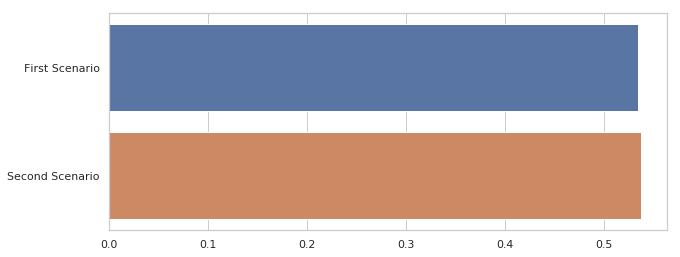

In [37]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,4)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores['mean-roc_auc_score'],test_scores_v1['mean-roc_auc_score']],
                 y=['First Scenario','Second Scenario'])
ax.set(xlim=(0, None))